# Data plot contours

In [62]:
'''
---------------------------------------------------
Simple way to fit Three 2D-Gaussians for FOXSI3-SLF Data (Dark corrected)
Then get the FWHM as a function of the azimuthal angle
---------------------------------------------------

Goal: To fit Three 2D gaussians to the FOXSI3 SLF data corrected by darks.

Input:  1. Fits file with SLF Data taken with the Andor CCD Camera.
        2. Dark fits files for correction.

Run on terminal: ipython Data_Fit_Contour_FWHM.py

Output:
            1. Flat plots of the three 2D-Gaussians in Log scale.
            2. 3D plots of the three 2D-Gaussians.
            3. Plot of the difference Data vs. Fit in log scale.
            4. Print out the parameters for the three 2D-Gaussians and the offset.
            5. Plot of the FWHM as a function of the azimuthal angle

Date: Sep, 2019
Author: Milo
UC-Berkeley
'''

''' Workspace '''
## Import Packages:
from astropy import wcs
from astropy.io import fits as pyfits
from ndcube import NDCube
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch, LinearStretch
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
from scipy.optimize import brentq
import astropy.units as u
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import os

def RunFWHM(folder,XX,YY,filename,SaveFolder):

    ''' INPUTS '''

    XX = XX   ## in arcmins
    YY = YY   ## in arcmins

    print('Yaw = {0} arcmin, Pitch = {1}'.format(str(XX),str(YY)))

    '''' File names: '''
    filename=filename
    #filename = 'X2-No-WA-PSF/FOXSI3_X2_CCD_T6Sx6_10kV_0p02mA_-6p4arcminX_+6p4arcminY.fits'  ## name of your data fits file.
    darkfilename = '/Volumes/Pandora/FOXSI/OpCal/FOXSI-3_2018Mar/X2-10Shells/CCD/Darks/Dark1_FOXSI3_X2_CCD_T6Sx6_10kV_0p02mA_0arcminX_0arcminY.fits'  ## name of your darks fits file.
    ## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
    ## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are
    ## indicated over the names of the files.

    ## Path to the folder where to find your data and darks:
    folder=folder
    #folder = '/Volumes/Pandora/FOXSI/OpCal/FOXSI-3_2018Mar/X2-10Shells/CCD/'
    ## Path to the folder where to save all the outcomes:
    SaveFolder = SaveFolder

    ## Workspace:
    ''' Plate scale '''
    distance = 2. * u.m ## FOXSI focal distance
    CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
    binning = 2. ## binning used for collecting data.
    plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

    ## Read fits files using astropy.io.fits
    fits = pyfits.open(filename)
    darkfits = pyfits.open(darkfilename)

    ## Create data array corrected by darks:
    data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)
    smax_pixel = np.unravel_index(np.argmax(data), data.shape)
    fov = [20, 20] ## [px,px]
    sdata = data[smax_pixel[0]-fov[0]:smax_pixel[0]+fov[0],smax_pixel[1]-fov[1]:smax_pixel[1]+fov[1]]/data.max()
    max_pixel = np.unravel_index(np.argmax(sdata), sdata.shape)

    ''' Create the WCS information '''
    wcs_dict = {
        'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
        'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
        'CUNIT1':'arcsec',
        'CUNIT2':'arcsec',
        'CDELT1': plate_scale.value, ## Plate scale in arcsec
        'CDELT2': plate_scale.value, ## Plate scale in arcsec
        'CRPIX1': 0.5 * sdata.shape[0] + 1,
        'CRPIX2': 0.5 * sdata.shape[1] + 1,
        'CRVAL1': 0,
        'CRVAL2': 0,
        'NAXIS1': sdata.shape[0],
        'NAXIS2': sdata.shape[1]
        }
    input_wcs = wcs.WCS(wcs_dict)

    ''' Create NDCube '''
    datacube = NDCube(sdata, input_wcs)

    ''' Definition of Two 2D-Gaussians function '''
    @models.custom_model
    def ThreeGaussians(x, y,
                    x_mean=0, y_mean=0, theta=0,
                    amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                    amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                    amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                    offset=0): ## offset
                    ''' Constrain positive values for the amplitudes '''
                    if amp1 < 0:
                        amp1 = 1e12
                    if amp2 < 0:
                        amp2 = 1e12
                    if amp3 < 0:
                        amp3 = 1e12

                    '''Define Sum of Gauss funtions'''
                    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
                    g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
                    g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
                    ''' Defining Offset '''
                    oset = models.Const2D(amplitude=offset)
                    return g1(x,y) + g2(x,y) + g3(x,y) + oset(x,y)

    ## Make X,Y,Z data for the TWO 2D-Gaussians:
    Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

    ''' Fit Three 2D-Gaussians '''
    ## Initial Guess :
    ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                            amp1=0.10111*np.max(datacube.data),
                            amp2 = 0.57882*np.max(datacube.data),
                            amp3 = 0.32008*np.max(datacube.data),
                            x1_stddev=5.0171, y1_stddev=4.0530,
                            x2_stddev=0.6243, y2_stddev=1.2561,
                            x3_stddev=1.5351, y3_stddev=2.2241,offset=0)

    ## Finding best fit:
    fit2DG = fitting.LevMarLSQFitter()
    ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=320) ## maxiter keyword is the max number of iterations.
    Zout = ThreeG_out(Xg, Yg)

    ## Individual Gaussian Functions:
    g1 = models.Gaussian2D(ThreeG_out.amp1.value, ThreeG_out.x_mean.value,
                            ThreeG_out.y_mean.value, ThreeG_out.x1_stddev.value,
                            ThreeG_out.y1_stddev.value, ThreeG_out.theta.value)
    g2 = models.Gaussian2D(ThreeG_out.amp2.value, ThreeG_out.x_mean.value,
                            ThreeG_out.y_mean.value, ThreeG_out.x2_stddev.value,
                            ThreeG_out.y2_stddev.value, ThreeG_out.theta.value)
    g3 = models.Gaussian2D(ThreeG_out.amp3.value, ThreeG_out.x_mean.value,
                            ThreeG_out.y_mean.value, ThreeG_out.x3_stddev.value,
                            ThreeG_out.y3_stddev.value, ThreeG_out.theta.value)
    ### Individual Gaussian Arrays:
    G1 = g1(Xg, Yg)
    G2 = g2(Xg, Yg)
    G3 = g3(Xg, Yg)

    ''' R^2 function definition '''
    ## More info: https://en.wikipedia.org/wiki/Coefficient_of_determination
    def RSquared(data,model):
        ## The closest to 1, the better is the fit.
        ss_err=(model.fit_info['fvec']**2).sum()
        ss_tot=((data-data.mean())**2).sum()
        return 1-(ss_err/ss_tot)
    ''' Estimate R^2 '''
    RS3G = RSquared(datacube.data, fit2DG)
    '''  Chi Square '''
    chisq = scipy.stats.chisquare(datacube.data[np.abs(Zout) >= 1e-15], f_exp=Zout[np.abs(Zout) >= 1e-15])

    ''' Print what the amplitud ratios are '''
    print('*'*30,file=f)
    print('Parameters for {0} Yaw & {1} Pitch : '.format(str(XX),str(YY)),file=f)
    print('The amplitud ratios for the guessed three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
        .format(round(ThreeG_guess.amp1.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
                round(ThreeG_guess.amp2.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
                round(ThreeG_guess.amp3.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
                ),file=f)
    print('The amplitud ratios for the three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
        .format(round(ThreeG_out.amp1.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
                round(ThreeG_out.amp2.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
                round(ThreeG_out.amp3.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
                ),file=f)
    print('The standard deviation for the three 2D-Gaussians are: S1x = {0:.5f}, S1y = {1:.5f}, S2x = {2:.5f}, S2y = {3:.5f}, S3x = {4:.5f}, and S3y = {5:.5f}.'
        .format(round(ThreeG_out.x1_stddev.value,5),
                round(ThreeG_out.y1_stddev.value,5),
                round(ThreeG_out.x2_stddev.value,5),
                round(ThreeG_out.y2_stddev.value,5),
                round(ThreeG_out.x3_stddev.value,5),
                round(ThreeG_out.y3_stddev.value,5),
                ),file=f)
    phi = np.rad2deg(ThreeG_out.theta.value-(ThreeG_out.theta.value//np.pi)*np.pi)
    print('Offset = {0:.5f}'.format(round(ThreeG_out.offset.value,5)),file=f)
    print('Angle = {0:.5f} degrees'.format(round(phi,3)),file=f)
    print('$R^2$ for three gaussians is {0:.5f}'.format(round(RS3G,5)),file=f)
    print('$chi^2$ for three gaussians is {0:.5f}'.format(round(chisq[0]/(Zout.shape[0]*Zout.shape[1]),5)),file=f)

    ''' Estimate of the FWHM on X&Y '''

    def x_fwhm_minmax(mask,Xt):
        xrange = []
        for xi in range (0,len(Xt)):
            if (mask[xi,:].any()==True):
                xrange.append(Xt[xi,0])
        return(xrange[0],xrange[-1])

    def G3y(y,x,G3): ## Flip argument order. Needed to find zeros on y-axis.
        return G3(x,y)
    maximum = ThreeG_out.amp1.value \
                + ThreeG_out.amp2.value \
                + ThreeG_out.amp3.value
    half_maximum = 0.5 * maximum
    ''' Find the FWHM '''
    def find_fwhm(G3,x): ## Input should be a 3-2D-Gaussian Function. e.g. ThreeG_out
        factor = 4*np.sqrt(2*np.log(2))*(G3.y1_stddev+
                                        G3.y2_stddev+G3.y3_stddev)
        steps = 0.5
        ymax = steps*np.argmax([ThreeG_out(x,yi) for yi in np.arange(0,len(datacube.data),steps)])
        y_fwhm_down = brentq(G3y,ymax-factor,ymax,args=(x,G3))
        y_fwhm_up = brentq(G3y,ymax,ymax+factor,args=(x,G3))
        return (y_fwhm_down,y_fwhm_up)

    def find_fwhmY(G3,y): ## Input should be a 3-2D-Gaussian Function. e.g. ThreeG_out
        factor = 4*np.sqrt(2*np.log(2))*(G3.x1_stddev+
                                        G3.x2_stddev+G3.x3_stddev)
        steps = 0.5
        xmax = steps*np.argmax([ThreeG_out(xi,y) for xi in np.arange(0,len(datacube.data),steps)])
        x_fwhm_left = brentq(ThreeG_out,xmax-factor,xmax,args=(y,G3))
        x_fwhm_right = brentq(ThreeG_out,xmax,xmax+factor,args=(y,G3))
        return (x_fwhm_left,x_fwhm_right)

    def y_fwhm_minmax(mask,Yt):
        yrange = []
        for yi in range (0,len(Yt)):
            if (mask[:,yi].any()==True):
                yrange.append(Yt[0,yi])
        return(yrange[0],yrange[-1])

    ThreeG_out.offset -= half_maximum
    npoints = 50

    ## Needed to determine the size of the FWHM:
    steps = 80j ## Play with this value to close the FWHM or to make it converge.
    Xt, Yt = np.mgrid[0:datacube.data.shape[0]:steps, 0:datacube.data.shape[1]:steps]
    ZoutHR = ThreeG_out(Xt,Yt) ## increasing the resolution of Zout
    mask = np.greater(ZoutHR,0)
    x_fwhm = ThreeG_out.x_mean+(ThreeG_out.x_mean -
                    x_fwhm_minmax(mask,Xt)[0])*np.sin((np.pi/2)*np.linspace(-1,1,npoints))
    y_fwhm_up_l,y_fwhm_down_l = [],[]
    for x in x_fwhm:
        y_fwhm = find_fwhm(ThreeG_out,x)
        y_fwhm_down_l.append(y_fwhm[0])
        y_fwhm_up_l.append(y_fwhm[1])
    y_fwhm_down = np.array(y_fwhm_down_l)
    y_fwhm_up = np.array(y_fwhm_up_l)

    ##Mapping along the vertical axis
    y_fwhm2 = ThreeG_out.y_mean+(ThreeG_out.y_mean -
                    y_fwhm_minmax(mask,Yt)[0])*np.sin((np.pi/2)*np.linspace(-1,1,npoints))
    x_fwhm_right_l,x_fwhm_left_l = [],[]
    for y in y_fwhm2:
        x_fwhm2 = find_fwhmY(ThreeG_out,y)
        x_fwhm_left_l.append(x_fwhm2[0])
        x_fwhm_right_l.append(x_fwhm2[1])
    x_fwhm_left = np.array(x_fwhm_left_l)
    x_fwhm_right = np.array(x_fwhm_right_l)

    ThreeG_out.offset += half_maximum

    levels = np.array([.2,.4,.6,.8,.92]) ## Set level at half the maximum
    CFWHM_dat = plt.contour(datacube.data, levels,colors='black') ## Generate contour Data
    CFWHM_fit = plt.contour(Zout, levels,colors='black') ## Generate contour Fit
    plt.close() ## needed to avoid ploting contours at this time.
    
    CX_Dat, CY_Dat = [], []
    for c in CFWHM_dat.collections:
        v = c.get_paths()[0].vertices
        CX_Dat.append(v[:,0]-ThreeG_out.x_mean.value)
        CY_Dat.append(v[:,1]-ThreeG_out.y_mean.value)

    CX_Fit, CY_Fit = [], []
    for c in CFWHM_fit.collections:
        v = c.get_paths()[0].vertices
        CX_Fit.append(v[:,0]-ThreeG_out.x_mean.value)
        CY_Fit.append(v[:,1]-ThreeG_out.y_mean.value)

    return ((CX_Dat,CY_Dat), (CX_Fit,CY_Fit))
    #return CFWHM_fit
    
    #XX_fwhm = np.concatenate((y_fwhm_down,y_fwhm_up,y_fwhm2,y_fwhm2), axis=0)
    #YY_fwhm = np.concatenate((x_fwhm,x_fwhm,x_fwhm_left,x_fwhm_right), axis=0)
    
    #return np.array([XX_fwhm-ThreeG_out.y_mean.value,YY_fwhm-ThreeG_out.x_mean.value])

''' Main program '''
## Path to the folder where to save all the outcomes:
SaveFolder = '/Users/Kamilobu/Desktop/test/'

## LogFile Creation:
if os.path.exists(SaveFolder+'LogFile.txt'):
    os.remove(SaveFolder+'LogFile.txt')
f = open(SaveFolder+'LogFile.txt', 'w')
print('LogFile',file=f)


## Looping over the whole set of data.
folder = '/Volumes/Pandora/FOXSI/OpCal/FOXSI-3_2018Mar/X2-10Shells/CCD/X2-No-WA-PSF/'
str_indices_vh = {'0p5a':'','1a'  :'','2a'  :'','3a'  :'','5a'  :'','7a'  :'','9a'  :''}
str_indices_ds = {'0p4a':'','0p7a':'','1p4a'  :'','2p1a'  :'','3p5a'  :'','4p9a'  :'','6p4a'  :''}

flist_000, flist_090, flist_045, flist_135 = [], [], [], []
#flist_000.append(glob.glob(data_dir + '*0a*' + '*0a*.fits')[0])
for key in str_indices_vh:
    flist_000.append(glob.glob(folder + '*+' + key + '*0a*.fits')[0])
    flist_000.append(glob.glob(folder + '*-' + key + '*0a*.fits')[0])
    flist_090.append(glob.glob(folder + '*0a*+' + key + '*.fits')[0])
    flist_090.append(glob.glob(folder + '*0a*-' + key + '*.fits')[0])

for key in str_indices_ds:
    flist_045.append(glob.glob(folder + '*+' + key + '*+' + key + '*.fits')[0])
    flist_045.append(glob.glob(folder + '*-' + key + '*-' + key + '*.fits')[0])
    flist_135.append(glob.glob(folder + '*+' + key + '*-' + key + '*.fits')[0])
    flist_135.append(glob.glob(folder + '*-' + key + '*+' + key + '*.fits')[0])

nlist_000_XX = [0.5, -0.5, 1.0, -1.0, 2.0, -2.0, 3.0, -3.0, 5.0, -5.0, 7.0, -7.0, 9.0, -9.0]
nlist_045_XX = [0.4, -0.4, 0.7, -0.7, 1.4, -1.4, 2.1, -2.1, 3.5, -3.5, 4.9, -4.9, 6.4, -6.4]

CDat_all, CFit_all, XX_all, YY_all = [], [], [], []
## On axis
filename = '/Volumes/Pandora/FOXSI/OpCal/FOXSI-3_2018Mar/X2-10Shells/CCD/X2-No-WA-PSF/FOXSI3_X2_CCD_T6Sx6_10kV_0p02mA_0arcminX_0arcminY.fits'
XX_all.append(0.0); YY_all.append(0.0)
CDat, CFit = RunFWHM(folder,0.0,0.0,filename,SaveFolder)
CDat_all.append(CDat); CFit_all.append(CFit)

## 000 - The negative sign for XX is due to the mirroring flip of the CCD.
for XX, filename in zip(nlist_000_XX,flist_000):
    XX_all.append(-XX); YY_all.append(0.0)
    CDat, CFit = RunFWHM(folder,-XX,0.0,filename,SaveFolder)
    CDat_all.append(CDat); CFit_all.append(CFit)

## 090
for YY, filename in zip(nlist_000_XX,flist_090):
    XX_all.append(0.0); YY_all.append(YY)
    CDat, CFit = RunFWHM(folder,0.0,YY,filename,SaveFolder)
    CDat_all.append(CDat); CFit_all.append(CFit)

## 045
for XX,YY, filename in zip(nlist_045_XX,nlist_045_XX,flist_045):
    XX_all.append(-XX); YY_all.append(YY)
    CDat, CFit = RunFWHM(folder,-XX,YY,filename,SaveFolder)
    CDat_all.append(CDat); CFit_all.append(CFit)

## 135
for XX,YY, filename in zip(nlist_045_XX,nlist_045_XX,flist_135):
    XX_all.append(-XX); YY_all.append(-YY)
    CDat, CFit = RunFWHM(folder,-XX,-YY,filename,SaveFolder)
    CDat_all.append(CDat); CFit_all.append(CFit)


## Next three lines for testing:
#filename = flist_045[-3]
#XX = nlist_045_XX[-3]
#YY = nlist_045_XX[-3]
#CDat, CFit = RunFWHM(folder,-XX,YY,filename,SaveFolder)
print('Final!')


Yaw = 0.0 arcmin, Pitch = 0.0
Yaw = -0.5 arcmin, Pitch = 0.0
Yaw = 0.5 arcmin, Pitch = 0.0
Yaw = -1.0 arcmin, Pitch = 0.0
Yaw = 1.0 arcmin, Pitch = 0.0
Yaw = -2.0 arcmin, Pitch = 0.0
Yaw = 2.0 arcmin, Pitch = 0.0
Yaw = -3.0 arcmin, Pitch = 0.0
Yaw = 3.0 arcmin, Pitch = 0.0


Yaw = -5.0 arcmin, Pitch = 0.0
Yaw = 5.0 arcmin, Pitch = 0.0
Yaw = -7.0 arcmin, Pitch = 0.0
Yaw = 7.0 arcmin, Pitch = 0.0
Yaw = -9.0 arcmin, Pitch = 0.0
Yaw = 9.0 arcmin, Pitch = 0.0
Yaw = 0.0 arcmin, Pitch = 0.5
Yaw = 0.0 arcmin, Pitch = -0.5
Yaw = 0.0 arcmin, Pitch = 1.0
Yaw = 0.0 arcmin, Pitch = -1.0
Yaw = 0.0 arcmin, Pitch = 2.0
Yaw = 0.0 arcmin, Pitch = -2.0
Yaw = 0.0 arcmin, Pitch = 3.0
Yaw = 0.0 arcmin, Pitch = -3.0
Yaw = 0.0 arcmin, Pitch = 5.0
Yaw = 0.0 arcmin, Pitch = -5.0
Yaw = 0.0 arcmin, Pitch = 7.0
Yaw = 0.0 arcmin, Pitch = -7.0
Yaw = 0.0 arcmin, Pitch = 9.0
Yaw = 0.0 arcmin, Pitch = -9.0
Yaw = -0.4 arcmin, Pitch = 0.4
Yaw = 0.4 arcmin, Pitch = -0.4
Yaw = -0.7 arcmin, Pitch = 0.7
Yaw = 0.7 arcmin, Pitch = -0.7
Yaw = -1.4 arcmin, Pitch = 1.4
Yaw = 1.4 arcmin, Pitch = -1.4
Yaw = -2.1 arcmin, Pitch = 2.1
Yaw = 2.1 arcmin, Pitch = -2.1
Yaw = -3.5 arcmin, Pitch = 3.5
Yaw = 3.5 arcmin, Pitch = -3.5
Yaw = -4.9 arcmin, Pitch = 4.9
Yaw = 4.9 arcmin, Pitch = -4.9
Yaw = -6.4 arcmin,

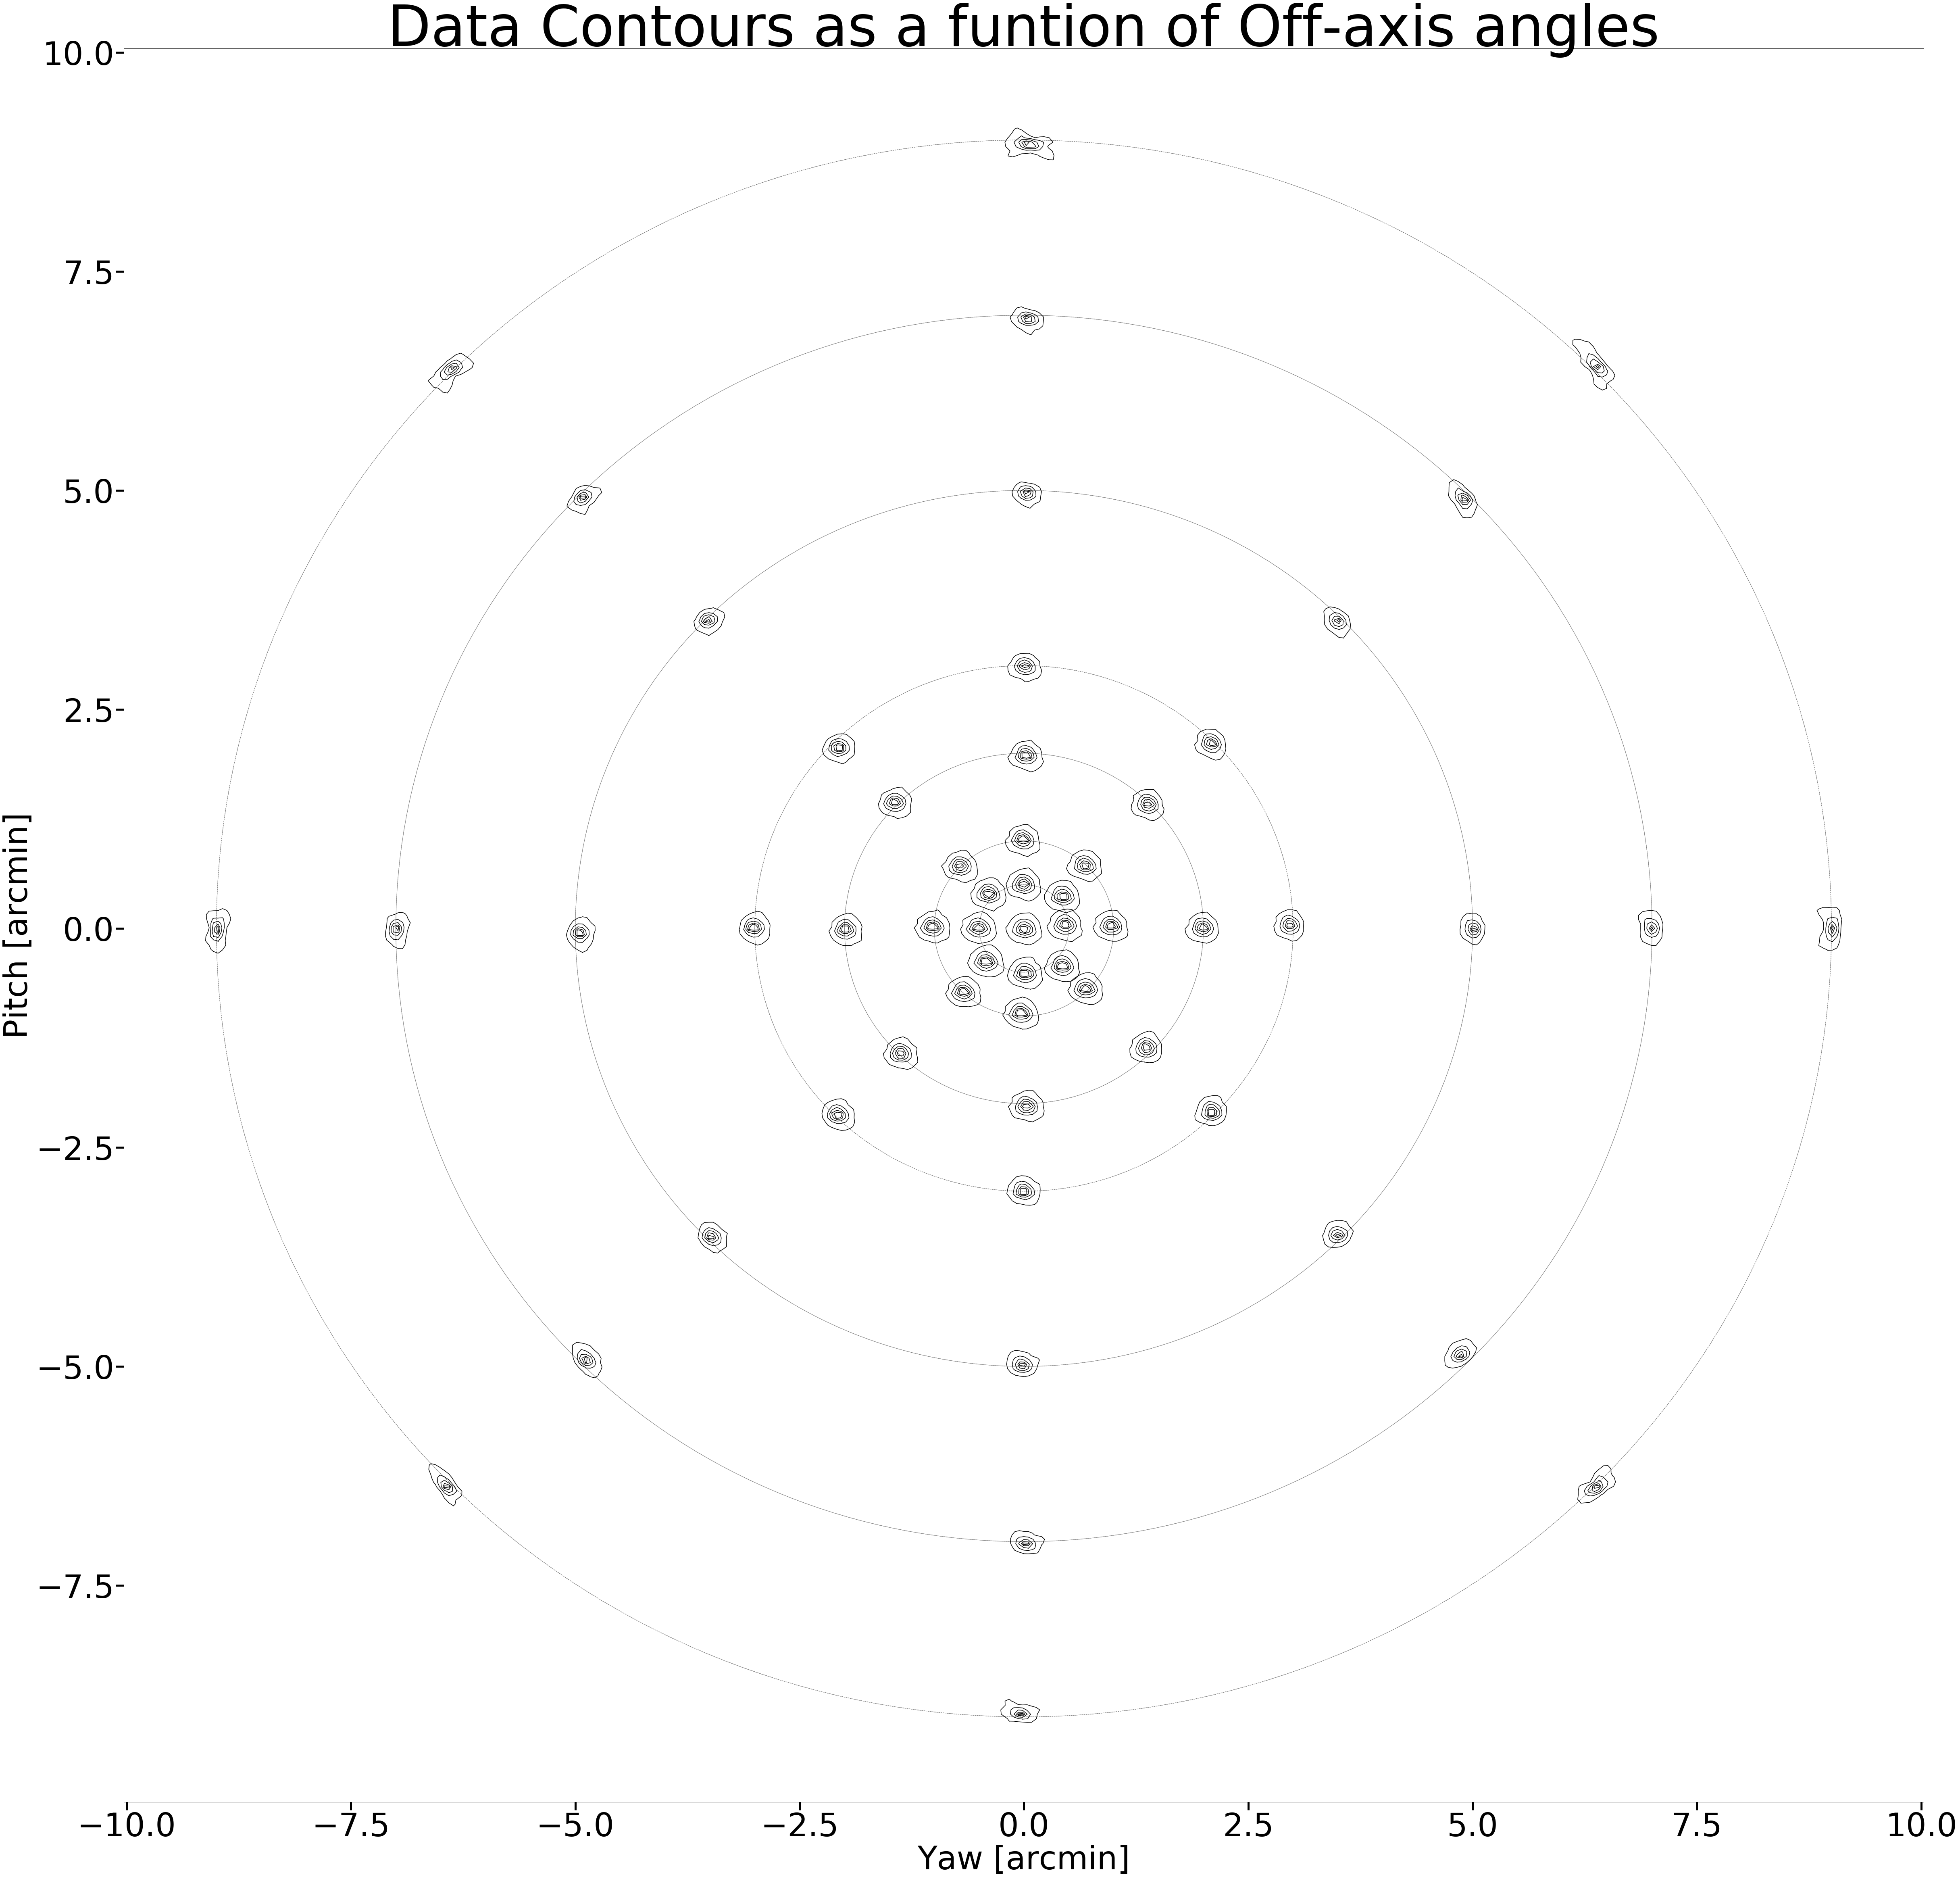

In [65]:
''' Plot of the FWHMs as function of the off-axis angles - with a factor of 6 '''
scale=.05 ## this is 60*0.05 = 3 times the actual size of the contours 
fig, ax1 = plt.subplots(figsize=(80,80))
for c in nlist_000_XX:
    circle = plt.Circle((0, 0), c, color='gray', linestyle='dashed', fill=False)
    ax1.add_artist(circle)
for i in range(0,len(CDat_all)):
    for j in range (0,len(CDat_all[0][0])):
        ax1.plot(np.array(scale*CDat_all[i][0][j])+XX_all[i],scale*np.array(CDat_all[i][1][j])+YY_all[i],color='k')
    #ax1.plot(np.array(CDat_all[i][0])+XX_all[i],np.array(CDat_all[i][1])+YY_all[i],c='blue',s=6)
ax1.tick_params(labelsize=80,length=20, width=5)
ax1.set_xlabel('Yaw [arcmin]',fontsize=80);ax1.set_ylabel('Pitch [arcmin]',fontsize=80) 
ax1.set_title('Data Contours as a funtion of Off-axis angles',fontsize=140)
plt.savefig(SaveFolder+'DatCont_vs_OffAxis.png')

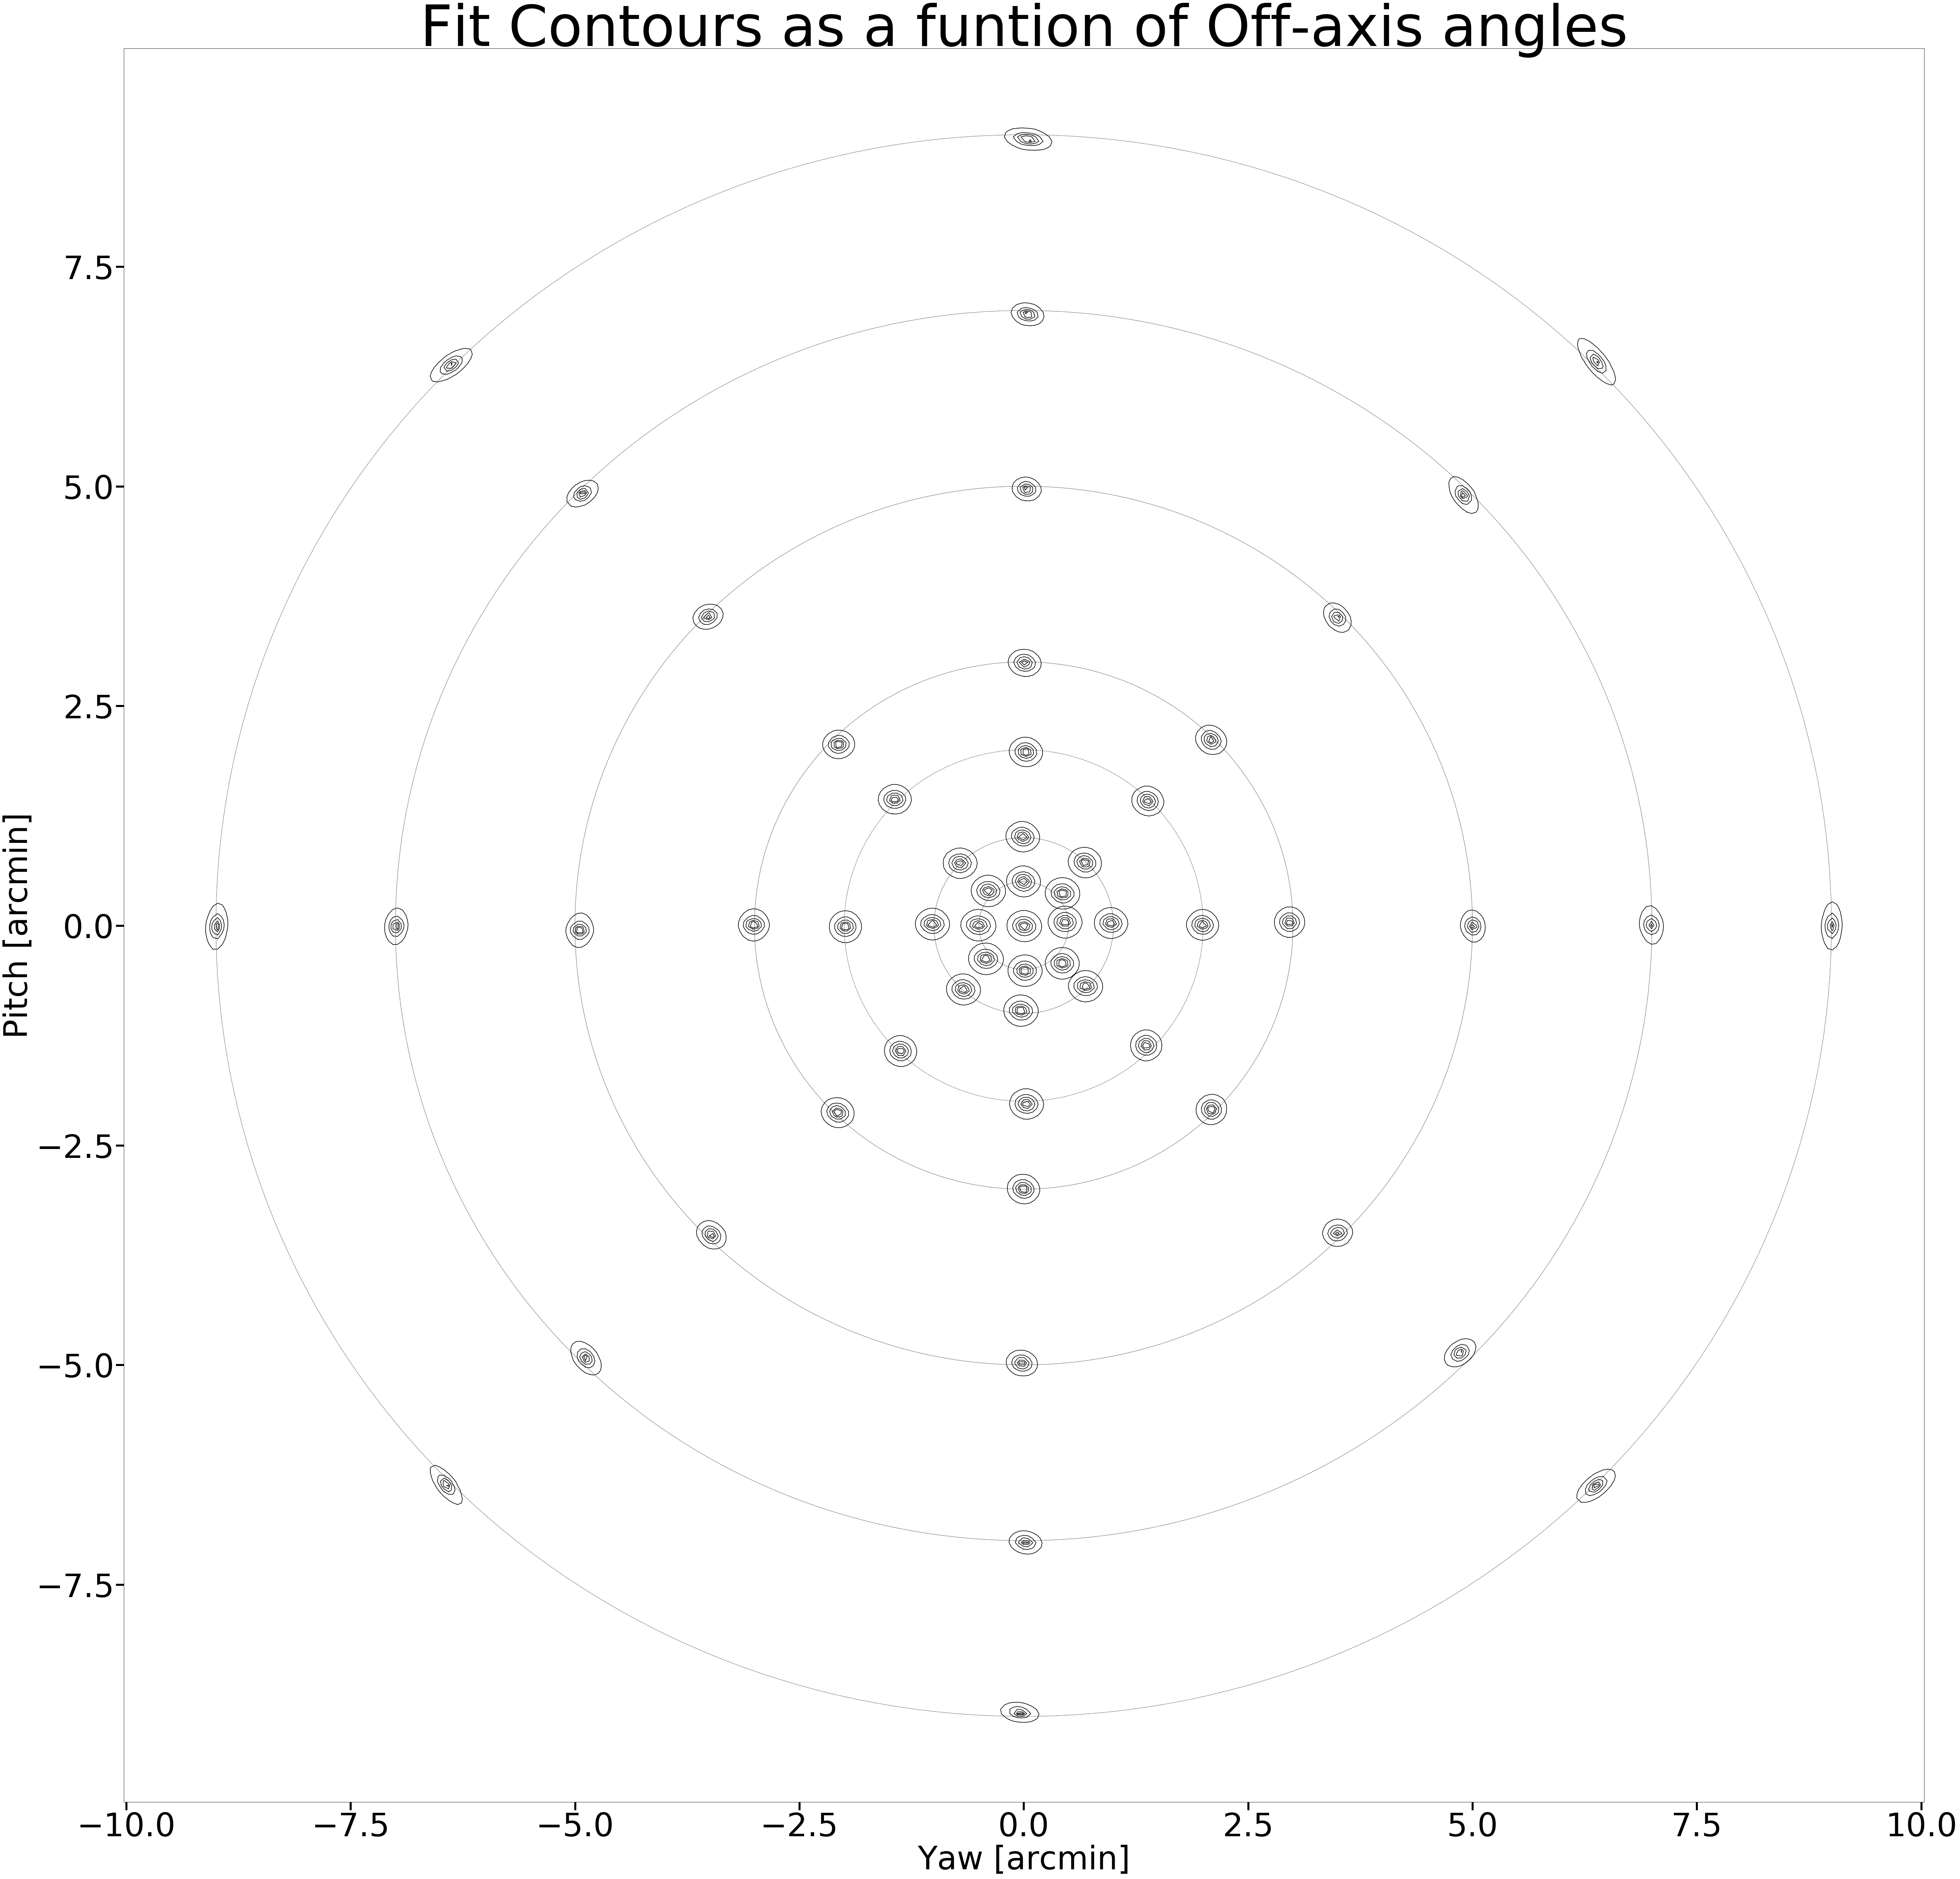

In [67]:
''' Plot of the FWHMs as function of the off-axis angles - with a factor of 6 '''
scale=.05 ## this is 60*0.05 = 3 times the actual size of the contours 
fig, ax1 = plt.subplots(figsize=(80,80))
for c in nlist_000_XX:
    circle = plt.Circle((0, 0), c, color='gray', linestyle='dashed', fill=False)
    ax1.add_artist(circle)
for i in range(0,len(CFit_all)):
    for j in range (0,len(CFit_all[0][0])):
        ax1.plot(np.array(scale*CFit_all[i][0][j])+XX_all[i],scale*np.array(CFit_all[i][1][j])+YY_all[i],color='k')
    #ax1.plot(np.array(CDat_all[i][0])+XX_all[i],np.array(CDat_all[i][1])+YY_all[i],c='blue',s=6)
ax1.tick_params(labelsize=80,length=20, width=5)
ax1.set_xlabel('Yaw [arcmin]',fontsize=80);ax1.set_ylabel('Pitch [arcmin]',fontsize=80) 
ax1.set_title('Fit Contours as a funtion of Off-axis angles',fontsize=140)
plt.savefig(SaveFolder+'FittCont_vs_OffAxis.png')

# NDCube

In [198]:
import numpy as np
data0 = np.ones((3, 4, 5))

import astropy.wcs
wcs_input_dict = {
'CTYPE1': 'WAVE    ', 'CUNIT1': 'Angstrom', 'CDELT1': 0.2, 'CRPIX1': 0, 'CRVAL1': 10, 'NAXIS1': 5,
'CTYPE2': 'HPLT-TAN', 'CUNIT2': 'deg', 'CDELT2': 0.5, 'CRPIX2': 2, 'CRVAL2': 0.5, 'NAXIS2': 4,
'CTYPE3': 'HPLN-TAN', 'CUNIT3': 'deg', 'CDELT3': 0.4, 'CRPIX3': 2, 'CRVAL3': 1, 'NAXIS3': 3}
input_wcs = astropy.wcs.WCS(wcs_input_dict)

from ndcube import NDCube
dcube = NDCube(data0, input_wcs)

In [199]:
dcube.wcs == input_wcs

True

In [209]:
dcube.wcs.wcs.cdelt

array([2.e-11, 5.e-01, 4.e-01])

In [49]:
input_wcs.wcs.cdelt = input_wcs.wcs.cdelt /10